In [1]:
# Numpy
import numpy as np

# Pandas
import geopandas as gpd

# Rasterio
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

# Sklearn
from sklearn.model_selection import train_test_split

# Matplotlib
import matplotlib.pyplot as plt

In [2]:
# Load the roads data
roads_data = gpd.read_file('data/tamale-231113-roads.geojson')

# Filter out non-LineString geometries
roads_data = roads_data[roads_data.geometry.type == 'LineString']

# Reproject to Web Mercator (EPSG: 3395)
roads_data = roads_data.to_crs(epsg=3395)

In [43]:
# Landsat images paths
landsat_directory = 'data/tamale_landsat/'
images_name_prefix = 'LC09_L2SP_194053_20231024_20231025_02_T1_SR_B'

# Create a list of the paths to the images to reproject
images_to_process_paths = [landsat_directory + images_name_prefix + str(i) + '.TIF' for i in range(1, 8)]

In [44]:
# Function to project the landsat image to Web Mercator (EPSG: 3395)
def reproject_landsat_image(landsat_image_path, output_path):
    with rasterio.open(landsat_image_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:3395', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:3395',
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:3395',
                    resampling=Resampling.nearest)

In [45]:

# Process each of the landsat images
for image_path in images_to_process_paths:
    reproject_landsat_image(image_path, image_path.replace('.TIF', '_reprojected.TIF'))

# Create a list of the paths to the reprojected images
images_paths = [landsat_directory + images_name_prefix + str(i) + '_reprojected.TIF' for i in range(1, 8)]


In [57]:
class SatelliteRoadDataset(Dataset):
    def __init__(self, roads_data, images_paths, patch_size, transform=None):
        self.roads_data = roads_data
        self.images_paths = images_paths
        self.patch_size = patch_size
        self.transform = transform

        # Calculate the number of patches (all bands have the same dimensions)
        with rasterio.open(self.images_paths[0]) as src:
            self.img_width, self.img_height = src.width, src.height
        self.num_patches_x = self.img_width // self.patch_size
        self.num_patches_y = self.img_height // self.patch_size
        self.total_patches = self.num_patches_x * self.num_patches_y

    def __len__(self):
        return self.total_patches

    def __getitem__(self, index):
        # Calculate patch coordinates
        patch_x = (index % self.num_patches_x) * self.patch_size
        patch_y = (index // self.num_patches_x) * self.patch_size

        # Extract the satellite image patch
        patch_data = np.empty((len(self.images_paths), self.patch_size, self.patch_size), dtype=np.float32)
        for i, path in enumerate(self.images_paths):
            with rasterio.open(path) as src:
                patch_data[i, :, :] = src.read(1, window=Window(patch_x, patch_y, self.patch_size, self.patch_size))

        # Rasterize the road data for the corresponding patch
        #label_patch = self.rasterize_roads(patch_x, patch_y, self.patch_size) TODO: Fix this
        label_patch = np.zeros((self.patch_size, self.patch_size), dtype=np.uint8)

        # Normalize the satellite image patch
        for i in range(patch_data.shape[0]):
            patch_data[i, :, :] = self.normalize(patch_data[i, :, :])

        # Apply transformations if any
        if self.transform:
            patch_data = self.transform(patch_data)
            label_patch = self.transform(label_patch)

        return torch.from_numpy(patch_data), torch.from_numpy(label_patch)
    
    def normalize(self, band):
        # Min-max normalization
        min = band.min()
        max = band.max()
        if max - min == 0:
            return np.zeros(band.shape)
        else:
            return (band - min) / (max - min)

Number of patches: 169
First patch: torch.Size([7, 572, 572]) torch.Size([572, 572])


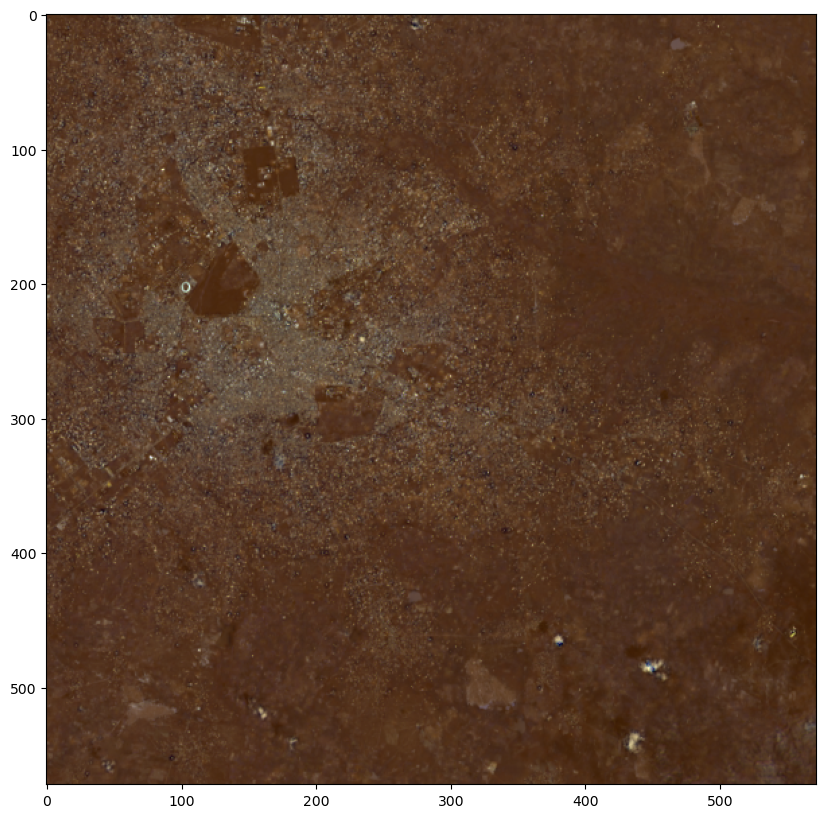

In [69]:
# Test the dataset
dataset = SatelliteRoadDataset(roads_data, images_paths, 572)
print('Number of patches:', len(dataset))
print('First patch:', dataset[1][0].shape, dataset[1][1].shape)
#print('Last patch:', dataset[-1][0].shape, dataset[-1][1].shape) TODO: fix this

# Plot one patch
bands = np.stack([dataset[148][0][i, :, :] for i in range(3)], axis=-1)
plt.figure(figsize=(10, 10))
plt.imshow(bands)
plt.show()

In [ ]:
# Implementation of the U-Net model
# Paper: https://arxiv.org/pdf/1505.04597.pdf

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsample
        self.conv1 = nn.Conv2d(7, 64, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu6 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu8 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(2)

        # Bridge
        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.relu9 = nn.ReLU(inplace=True)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.relu10 = nn.ReLU(inplace=True)

        # Upsample
        self.upconv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv11 = nn.Conv2d(1024, 512, 3, padding=1)
        self.relu11 = nn.ReLU(inplace=True)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu12 = nn.ReLU(inplace=True)

        self.upconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv13 = nn.Conv2d(512, 256, 3, padding=1)
        self.relu13 = nn.ReLU(inplace=True)
        self.conv14 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu14 = nn.ReLU(inplace=True)

        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv15 = nn.Conv2d(256, 128, 3, padding=1)
        self.relu15 = nn.ReLU(inplace=True)
        self.conv16 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu16 = nn.ReLU(inplace=True)

        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv17 = nn.Conv2d(128, 64, 3, padding=1)
        self.relu17 = nn.ReLU(inplace=True)
        self.conv18 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu18 = nn.ReLU(inplace=True)

        self.conv19 = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Downsample
        x1 = self.relu1(self.conv1(x))
        x1 = self.relu2(self.conv2(x1))
        x2 = self.maxpool1(x1)

        x2 = self.relu3(self.conv3(x2))
        x2 = self.relu4(self.conv4(x2))
        x3 = self.maxpool2(x2)

        x3 = self.relu5(self.conv5(x3))
        x3 = self.relu6(self.conv6(x3))
        x4 = self.maxpool3(x3)

        x4 = self.relu7(self.conv7(x4))
        x4 = self.relu8(self.conv8(x4))
        x5 = self.maxpool4(x4)

        # Bridge
        x5 = self.relu9(self.conv9(x5))
        x5 = self.relu10(self.conv10(x5))

        # Upsample
        x = self.upconv1(x5)
        x = torch.cat([x, x4], dim=1)  # Skip connection from x4
        x = self.relu11(self.conv11(x))
        x = self.relu12(self.conv12(x))

        x = self.upconv2(x)
        x = torch.cat([x, x3], dim=1)  # Skip connection from x3
        x = self.relu13(self.conv13(x))
        x = self.relu14(self.conv14(x))

        x = self.upconv3(x)
        x = torch.cat([x, x2], dim=1)  # Skip connection from x2
        x = self.relu15(self.conv15(x))
        x = self.relu16(self.conv16(x))

        x = self.upconv4(x)
        x = torch.cat([x, x1], dim=1)  # Skip connection from x1
        x = self.relu17(self.conv17(x))
        x = self.relu18(self.conv18(x))

        x = self.conv19(x)
        return x

In [ ]:
# Parameters
epochs = 10
optimizer_kwargs = {
    'lr': 1e-4,
    'weight_decay': 1e-4
}

# Load the model
model = UNet()

# Move the model to GPU if available
if (torch.cuda.is_available()):
    device = torch.device('cuda');
elif (torch.backends.mps.is_available()):
    device = torch.device('mps');
else:
    device = torch.device('cpu');
model.to(device)

# Create the dataset
dataset = SatelliteRoadDataset(roads_data, landsat_directory, patch_size=572)

# Splitting dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Loss function (binary cross entropy)
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), **optimizer_kwargs)

# Add learning rate scheduler
# not implemented for now but might be useful later

In [ ]:
# Training
def train(dataloader, model, loss_fn, optimizer):
    model.train() 
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Validation
@torch.no_grad()
def validate(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
# Training and validation Loop
best_loss = float('inf')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = validate(val_dataloader, model, loss_fn)
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model if it's the best so far
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_unet_model.pth')
        print("Saved the Best Model!")